In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import re
import csv
import torch
import yaml
import sys
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from scipy.stats import loguniform
import time
import warnings
warnings.filterwarnings('ignore')

In [2]:
X = pd.read_csv('../data/processed/vegf_augmented_processed.csv', index_col = 'Sequence')
y = pd.read_csv('../data/raw/VEGF_augmented_y.csv')

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state =42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state =4, stratify=y_train)

In [4]:
def modelfit(alg, dtrain, predictors,target, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=target.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval =False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], target)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(target.values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(target, dtrain_predprob))
                    
    #feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    #feat_imp.plot(kind='bar', title='Feature Importances')
    #plt.ylabel('Feature Importance Score')

In [5]:
target = y_train.copy()
assert isinstance(target, pd.DataFrame), "df needs to be a pd.DataFrame"
target.dropna(inplace=True)
indices_to_keep = ~target.isin([np.nan, np.inf, -np.inf]).any(axis=1)
target[indices_to_keep].astype(np.int32)

,Label
7275,0
5612,0
6602,0
4852,1
1044,1
...,...
3509,1
1580,1
6386,0
6500,0


In [6]:
#Choose all predictors except target & IDcols

predictors = [x for x in X_train.columns]
xgb1 = XGBClassifier(
 learning_rate =1e-5,
 n_estimators=1000,
 max_depth=100,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27,
 booster='gblinear',
 device = 'cuda')
modelfit(xgb1, X_train, predictors, y_train)


Model Report
Accuracy : 0.8354
AUC Score (Train): 0.945065


In [7]:
predict_val = xgb1.predict(X_val)


In [8]:
predict_val

array([1, 1, 1, ..., 1, 1, 0])

In [9]:
val_report = classification_report(y_val, predict_val, target_names=['positive','negative'])
print(val_report)

              precision    recall  f1-score   support

    positive       0.95      0.56      0.71       430
    negative       0.82      0.98      0.89       861

    accuracy                           0.84      1291
   macro avg       0.88      0.77      0.80      1291
weighted avg       0.86      0.84      0.83      1291



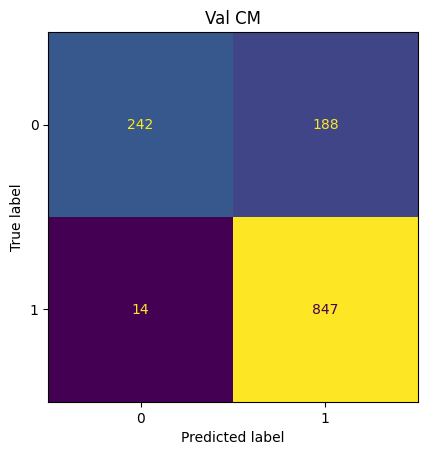

In [10]:
cm_val = confusion_matrix(y_val, predict_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val)
disp.plot(colorbar=False)
disp.ax_.set_title('Val CM')
plt.show()

In [11]:
predict_test = xgb1.predict(X_test)

In [12]:
test_report = classification_report(y_test, predict_test, target_names=['positive','negative'])
print(test_report)

              precision    recall  f1-score   support

    positive       0.95      0.53      0.68      1719
    negative       0.81      0.99      0.89      3442

    accuracy                           0.83      5161
   macro avg       0.88      0.76      0.78      5161
weighted avg       0.85      0.83      0.82      5161



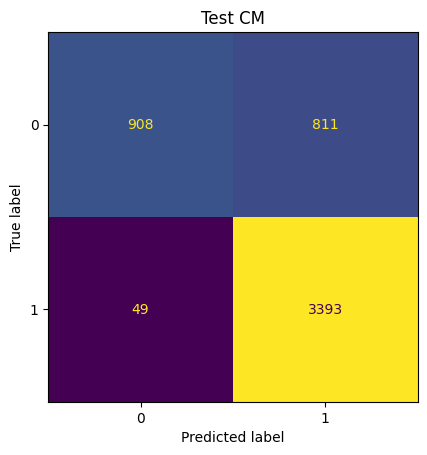

In [13]:
cm_test = confusion_matrix(y_test, predict_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test)
disp.plot(colorbar=False)
disp.ax_.set_title('Test CM')
plt.show()

# Random search

In [14]:
# Define dictionary with performance metrics
scoring = {'accuracy':make_scorer(accuracy_score), 
           'precision':make_scorer(precision_score),
           'recall':make_scorer(recall_score), 
           'f1_score':make_scorer(f1_score)}

In [15]:
# Definir el diccionario de hiperparámetros
xgb_params = dict(
              learning_rate = np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000),
              num_boost_round= np.linspace(1000, 5000, num=100).astype(int),
              max_depth=np.linspace(1, 50, num= 1).astype(int),
              nfold = np.linspace(1, 50, num= 1).astype(int),
           #   early_stopping_rounds = np.linspace(1, 100, num= 10).astype(int),
              booster = ['gbtree', 'gblinear', 'dart']
            
              )

In [16]:
          
              
xgtrain = xgb.DMatrix(X_train[predictors].values, label=target.values)              
xgb_model = XGBClassifier(device = 'cuda')

# Configurar RandomizedSearchCV
n_iter_search = 15
xgb_random_search = RandomizedSearchCV(
    xgb_model, param_distributions=xgb_params, n_iter=n_iter_search, scoring='roc_auc',cv=5,verbose=3)


# Ajustar el modelo
start_time = time.time()
xgb_random_search.fit(X_train,y_train)
end_time = time.time()
xgb_fit_time = end_time - start_time

print(f"Tiempo de ajuste del modelo: {xgb_fit_time} segundos")

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV 1/5] END booster=gblinear, learning_rate=0.00877433574824075, max_depth=1, nfold=1, num_boost_round=1161;, score=0.982 total time=   0.5s
[CV 2/5] END booster=gblinear, learning_rate=0.00877433574824075, max_depth=1, nfold=1, num_boost_round=1161;, score=0.979 total time=   0.5s
[CV 3/5] END booster=gblinear, learning_rate=0.00877433574824075, max_depth=1, nfold=1, num_boost_round=1161;, score=0.986 total time=   0.5s
[CV 4/5] END booster=gblinear, learning_rate=0.00877433574824075, max_depth=1, nfold=1, num_boost_round=1161;, score=0.981 total time=   0.5s
[CV 5/5] END booster=gblinear, learning_rate=0.00877433574824075, max_depth=1, nfold=1, num_boost_round=1161;, score=0.976 total time=   0.5s
[CV 1/5] END booster=dart, learning_rate=0.011623485299928238, max_depth=1, nfold=1, num_boost_round=4393;, score=0.968 total time=   3.7s
[CV 2/5] END booster=dart, learning_rate=0.011623485299928238, max_depth=1, nfold=1, num_b

In [17]:
xgb_random_search.best_estimator_

XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None,
              learning_rate=np.float64(0.460186599830911), max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=np.int64(1), max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              nfold=np.int64(1), num_boost_round=np.int64(4959), ...)

In [18]:
xgb_random_search.scorer_

make_scorer(roc_auc_score, response_method=('decision_function', 'predict_proba'))

In [19]:
# Predice valores de y
y_predict_xgb_train = xgb_random_search.predict(X_train)
y_predict_xgb_val = xgb_random_search.predict(X_val)
y_predict_xgb_test = xgb_random_search.predict(X_test)

# Calcula la precisión
accuracy_xgb_train = accuracy_score(y_train,y_predict_xgb_train)
accuracy_xgb_val = accuracy_score(y_val,y_predict_xgb_val)
accuracy_xgb_test = accuracy_score(y_test,y_predict_xgb_test)

print(f'Accuracy train {accuracy_xgb_train}')
print(f'Accuracy val {accuracy_xgb_val}')
print(f'Accuracy test {accuracy_xgb_test}')

Accuracy train 0.98171109733416
Accuracy val 0.9829589465530596
Accuracy test 0.9813989536911452


In [20]:
print(classification_report(y_train, y_predict_xgb_train, target_names=['positive','negative']))
print(classification_report(y_val,   y_predict_xgb_val, target_names=['positive','negative']))
print(classification_report(y_test,  y_predict_xgb_test, target_names=['positive','negative']))

              precision    recall  f1-score   support

    positive       0.98      0.96      0.97      2149
    negative       0.98      0.99      0.99      4303

    accuracy                           0.98      6452
   macro avg       0.98      0.98      0.98      6452
weighted avg       0.98      0.98      0.98      6452

              precision    recall  f1-score   support

    positive       0.99      0.96      0.97       430
    negative       0.98      1.00      0.99       861

    accuracy                           0.98      1291
   macro avg       0.98      0.98      0.98      1291
weighted avg       0.98      0.98      0.98      1291

              precision    recall  f1-score   support

    positive       0.98      0.96      0.97      1719
    negative       0.98      0.99      0.99      3442

    accuracy                           0.98      5161
   macro avg       0.98      0.98      0.98      5161
weighted avg       0.98      0.98      0.98      5161



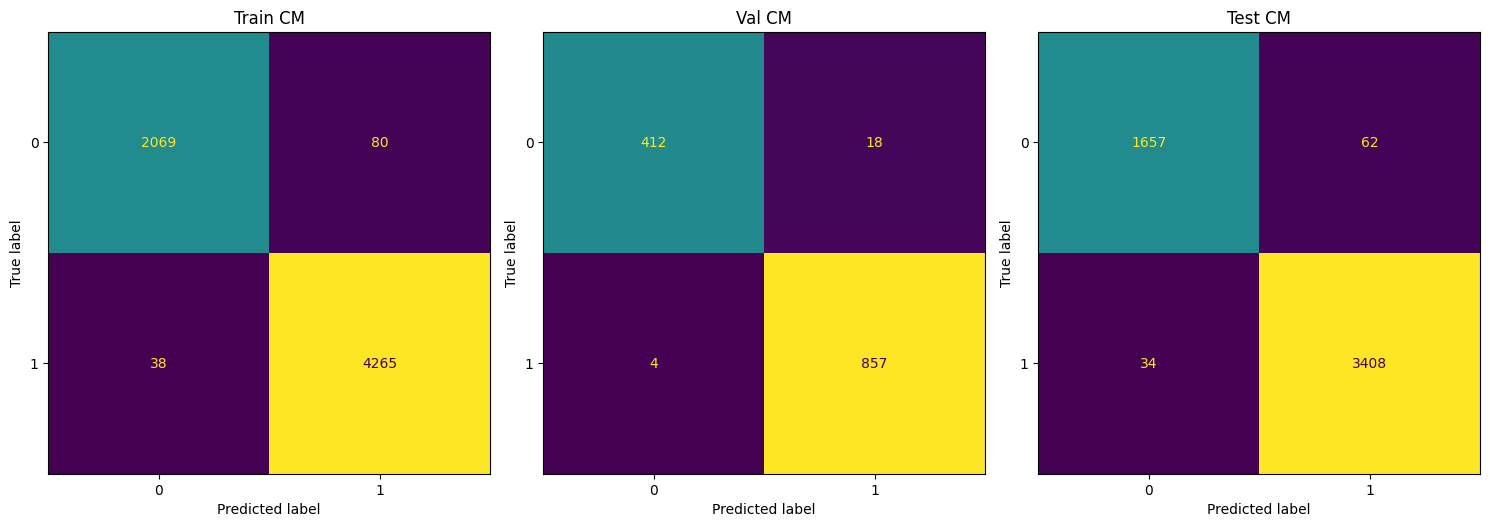

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 fila, 3 columnas

# Matriz de confusión para el conjunto de entrenamiento
cm_xgb_train = confusion_matrix(y_train, y_predict_xgb_train)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_train)
disp.plot(ax=axes[0], colorbar=False)
axes[0].set_title('Train CM')

# Matriz de confusión para el conjunto de validación
cm_xgb_val = confusion_matrix(y_val, y_predict_xgb_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_val)
disp.plot(ax=axes[1], colorbar=False)
axes[1].set_title('Val CM')

# Matriz de confusión para el conjunto de prueba
cm_xgb_test = confusion_matrix(y_test, y_predict_xgb_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_test)
disp.plot(ax=axes[2], colorbar=False)
axes[2].set_title('Test CM')

# Ajustar el espacio entre los gráficos
plt.tight_layout()
plt.show()


In [22]:
processed_generated_path = '../data/processed/generated_seqs_pfeature.csv'
generated_seqs = pd.read_csv(processed_generated_path, index_col=['Sequence'])

In [23]:
generated_predict = xgb_random_search.predict(generated_seqs)

In [ ]:
predict_results = pd.DataFrame(generated_predict)
predict_results.index = generated_seqs.index
predict_results.reset_index(inplace=True)
predict_results.rename(columns={'index':'Sequence', 0:'Label'}, inplace=True)
predict_positive = predict_results[predict_results['Label']==1]
#Solo la columna de secuencias se almacenara como CSV ya que los pasos siguientes solo requieren esta columna
predict_positive['Sequence'].to_csv('../data/processed/xgb_generated_predicted_positive.csv', index = False)
print(f'El modelo clasifico {len(predict_positive)} registros como positivos contra tumores')

El modelo clasifico 1735 registros como positivos contra tumores


In [25]:
sys.path.insert(1, '../')
from models.network import create_model

In [26]:
# funcion para cargar los modelos de peptideBERT
 
def load_bert_model(feature, device):
    config = yaml.load(open(f'../models/{feature}/config.yaml', 'r'), Loader=yaml.FullLoader)
    config['device'] = device
    model = create_model(config)
    model.load_state_dict(torch.load(f'../models/{feature}/model.pt',weights_only = False)['model_state_dict'], strict=False)
    return model

In [27]:
# ejecucion de peptideBERT

def predict_peptidebert(sequences, file_path):
    peptides =sequences.copy()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    MAX_LEN = max(map(len, sequences))
    # convert to tokens
    mapping = dict(zip(
        ['[PAD]','[UNK]','[CLS]','[SEP]','[MASK]','L',
        'A','G','V','E','S','I','K','R','D','T','P','N',
        'Q','F','Y','M','H','C','W'],
        range(30)
    ))

    
    for i in range(len(sequences)):
        sequences[i] = [mapping[c] for c in sequences[i]] 
        sequences[i].extend([0] * (MAX_LEN - len(sequences[i])))  # padding to max length
    
    results = pd.DataFrame({'Sequence':peptides})
    feats = ['hemo','sol','nf'] #definicion de las caracteristicas
    with torch.inference_mode():
        for c in feats:
            model = load_bert_model(c,device)
            preds = []
            for i in range(len(sequences)):
                input_ids = torch.tensor([sequences[i]]).to(device)
                attention_mask = (input_ids != 0).float()
                #output = float(model(input_ids, attention_mask)[0])
                output = int(model(input_ids, attention_mask)[0] > 0.5)
                #print(f'Secuencia {peptides[i]} {c]: {output}')
                preds.append(output)
                
            results = pd.concat([results,pd.DataFrame(preds, columns = [c]).astype(int)], axis=1)
    
    results.to_csv(file_path, index=False) #guarda los resultados en 
    return results
    

In [30]:
seqs = []
pos_seqs ='../data/processed/xgb_generated_predicted_positive.csv' # carga de archivo con las secuencias a clasificar
output_file = '../data/processed/xgb_generated_bert_vegf_features.csv'
with open(pos_seqs) as fp: # funcion para extraer las secuencias, ya que peptideBERT solo usa esta variable del dataset
    next(fp)
    f = csv.reader(fp, delimiter = ',', quotechar='"' )
    for line in f:
        seq = re.sub(r'[\[\'][\'\]]','',str(line)).strip()
        seqs.append(seq)
bert_results = predict_peptidebert(seqs,output_file)

Secuencias sin hemolisis calculadas usando peptideBERT: 1735


array([[<Axes: title={'center': 'sol'}>, <Axes: title={'center': 'nf'}>]],
      dtype=object)

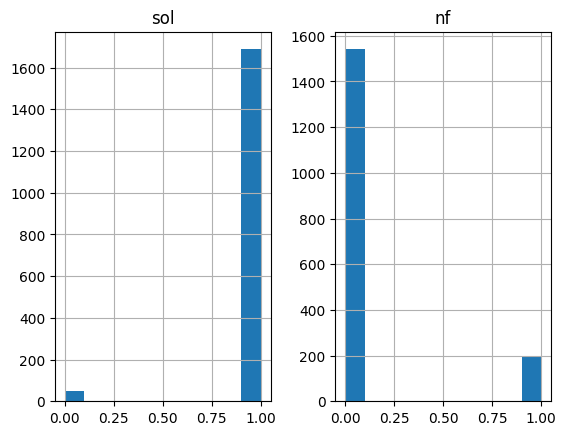

In [31]:
non_hemolytic = bert_results[bert_results['hemo']==0]
print(f'Secuencias sin hemolisis calculadas usando peptideBERT: {len(non_hemolytic)}')
non_hemolytic.hist(column=['sol','nf'])